In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog
import pandas as pd
import time
import pickle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Feature Extraction

### Load Data

In [2]:
vehicles_filenames = glob.glob('data/vehicles/*/*.png')
non_vehicles_filenames = glob.glob('data/non-vehicles/*/*.png')
print("Number of Vehicles Images: {}".format(len(vehicles_filenames)))
print("Number of Non-Vehicles Images: {}".format(len(non_vehicles_filenames)))

Number of Vehicles Images: 8956
Number of Non-Vehicles Images: 8907


### Data Visualization

In [3]:
random_vehicle_index = np.random.randint(0, len(vehicles_filenames))
random_non_vehicle_index = np.random.randint(0, len(non_vehicles_filenames))

vehicle_example = cv2.imread(vehicles_filenames[random_vehicle_index])
vehicle_example = cv2.cvtColor(vehicle_example, cv2.COLOR_BGR2RGB)
non_vehicle_example = mpimg.imread(non_vehicles_filenames[random_non_vehicle_index])
non_vehicle_example = cv2.cvtColor(non_vehicle_example, cv2.COLOR_BGR2RGB)

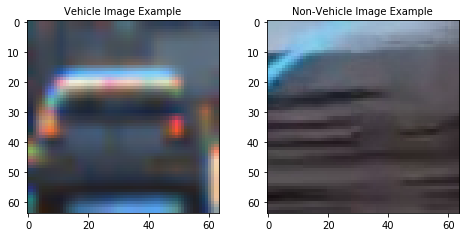

In [4]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 9))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('Vehicle Image Example', fontsize=10)
ax2.imshow(non_vehicle_example)
ax2.set_title('Non-Vehicle Image Example', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline Definition

### Bin Spatial

In [5]:
# Resize images to 32x32 pixels
def bin_spatial(img, size=(32, 32), vis=False):
    
    if not vis:
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    else:
        img = cv2.resize(img, size)
        features = img.ravel() 
        #Return the feature vector and the image for visualization
        return features, img

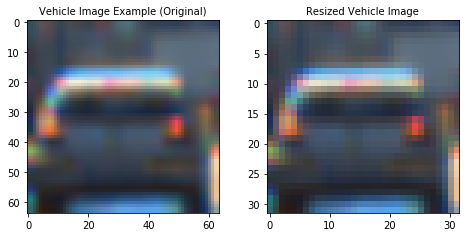

In [6]:
_, vehicle_example_bin = bin_spatial(vehicle_example, vis=True)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 9))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('Vehicle Image Example (Original)', fontsize=10)
ax2.imshow(vehicle_example_bin)
ax2.set_title('Resized Vehicle Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Histogram 

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], nbins, bins_range)
    ghist = np.histogram(img[:,:,1], nbins, bins_range)
    bhist = np.histogram(img[:,:,2], nbins, bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

Text(0.5,1,'B Histogram')

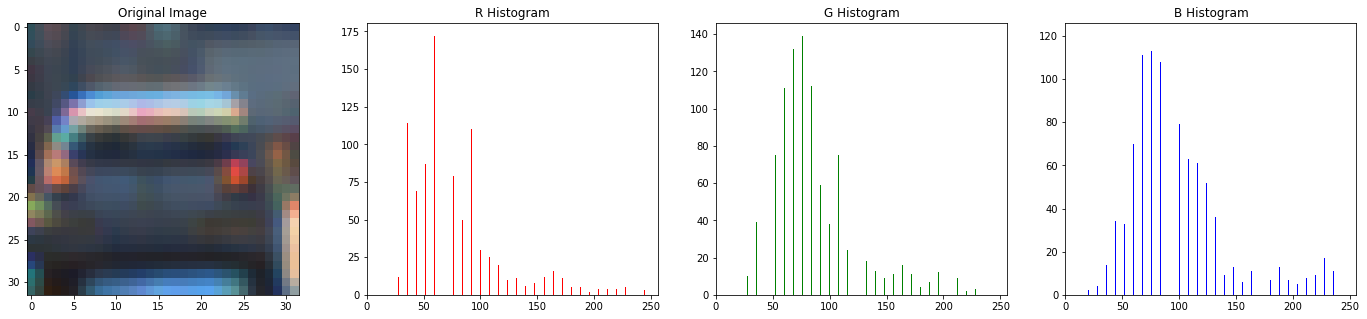

In [8]:
rhist, ghist, bhist, bin_centers, hist_features = color_hist(vehicle_example_bin)


# Plot a figure with all three bar charts
fig = plt.figure(figsize=(24,5))
plt.subplot(141)
plt.imshow(vehicle_example_bin)
plt.title('Original Image')
plt.subplot(142)
plt.bar(bin_centers, rhist[0], color='r')
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(143)
plt.bar(bin_centers, ghist[0], color='g')
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(144)
plt.bar(bin_centers, bhist[0], color='b')
plt.xlim(0, 256)
plt.title('B Histogram')

### Exploring Color Spaces

In [9]:
#Capture 3 images from Vehicles and Non-Vehicles
CS_vehicles = []

def cvt_color(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image) 
    return feature_image

for i in range(0,3):
    random_vehicle = np.random.randint(0, len(vehicles_filenames))
    img = cv2.imread(vehicles_filenames[random_vehicle])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    CS_vehicles.append(img)

    img_cvt = cvt_color(img, 'HSV')
    CS_vehicles.append(img_cvt)

for i in range(0,3):
    random_non_vehicle = np.random.randint(0, len(non_vehicles_filenames))
    img1 = cv2.imread(non_vehicles_filenames[random_non_vehicle])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    CS_vehicles.append(img1)

    img1_cvt = cvt_color(img1, 'HSV')
    CS_vehicles.append(img1_cvt)
    
CS_vehicles = np.asarray(CS_vehicles)

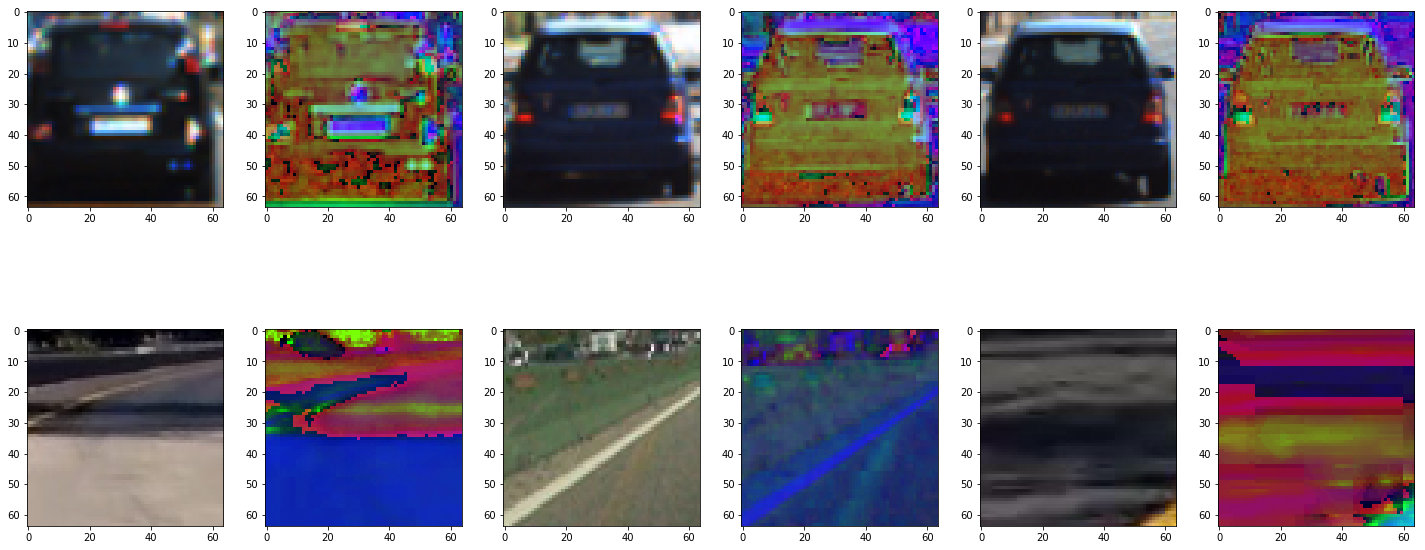

In [10]:
# Plot the result
f, ax = plt.subplots(2, 6, figsize=(20,9))
f.tight_layout()
for i in range(0,2): 
    for j in range(0,6):
        teste = (i*6)+j
        ax[i,j].imshow(CS_vehicles[(i*6)+j])

HSV looks like the cars are highlighted, so we'll stick with this option.

### HOG

In [11]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

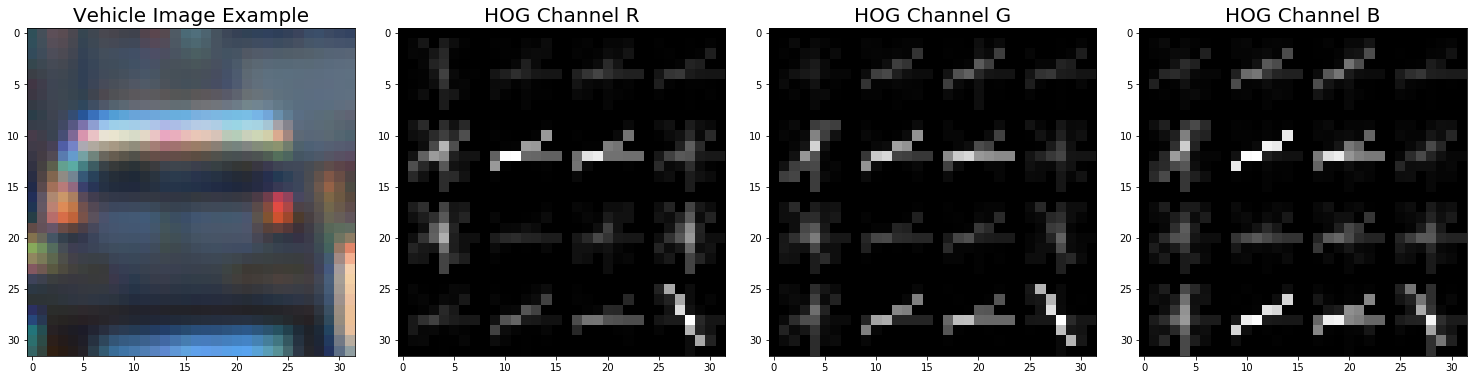

In [12]:
vehicle_hog = []
for channel in range(0, 3):
    _, vehicle_example_hog = get_hog_features(vehicle_example_bin[:,:,channel], orient = 8, pix_per_cell = 8, cell_per_block = 2, vis=True)
    vehicle_hog.append(vehicle_example_hog)
# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 9))
f.tight_layout()
ax1.imshow(vehicle_example_bin)
ax1.set_title('Vehicle Image Example', fontsize=20)
ax2.imshow(vehicle_hog[0], cmap='gray')
ax2.set_title('HOG Channel R', fontsize=20)
ax3.imshow(vehicle_hog[1], cmap='gray')
ax3.set_title('HOG Channel G', fontsize=20)
ax4.imshow(vehicle_hog[2], cmap='gray')
ax4.set_title('HOG Channel B', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Final Pipeline

In [13]:
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        img = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        feature_image = cvt_color(img, cspace)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() to get color histogram features
        _,_,_,_,color_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Apply get_hog_features() to get HOG features
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, color_features, hog_features)))
    # Return list of feature vectors
    return features

### Hyperparameter selection

In [14]:
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)
orient = 8
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
y_start_stop = [400, 650]

### Final step for feature extraction

In [113]:
vehicles_features = extract_features(vehicles_filenames, cspace=colorspace, spatial_size=spatial_size,
                                     hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                     pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
non_vehicles_features = extract_features(non_vehicles_filenames, cspace=colorspace, spatial_size=spatial_size,
                                         hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

In [115]:
# Create an array stack of feature vectors
X = np.vstack((vehicles_features, non_vehicles_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(vehicles_features)), np.zeros(len(non_vehicles_features))))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

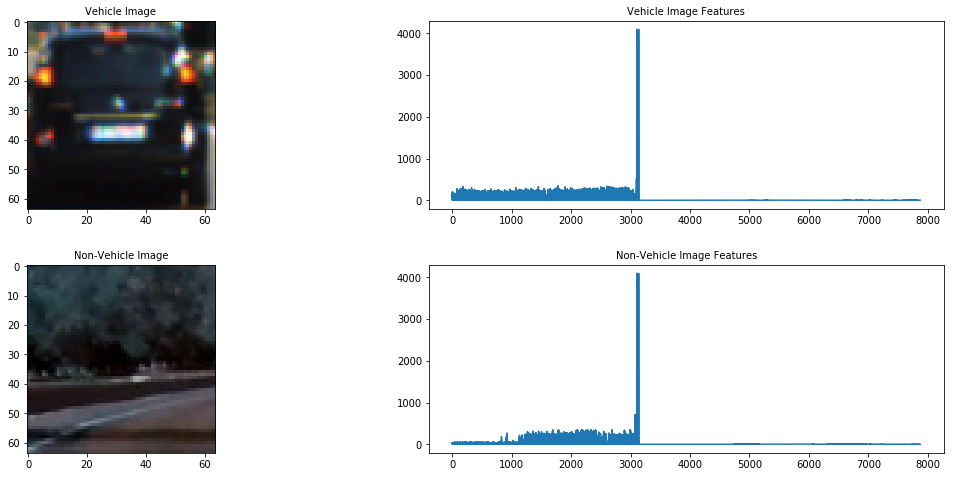

In [32]:
# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 4))
f.tight_layout()
ax1.imshow(vehicle_example)
ax1.set_title('Vehicle Image', fontsize=10)
ax2.plot(X[random_vehicle_index])
ax2.set_title('Vehicle Image Features', fontsize=10)
ax3.imshow(non_vehicle_example)
ax3.set_title('Non-Vehicle Image', fontsize=10)
ax4.plot(X[len(vehicles_features) + random_non_vehicle_index])
ax4.set_title('Non-Vehicle Image Features', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=1.5, bottom=0.)

#### Saving data to .csv

In [19]:
np.savetxt('features_augmented.csv', X, delimiter=',')
np.savetxt('labels_augmented.csv', y, delimiter=',')

# Classification

### Load Data

In [15]:
X = np.asarray(pd.read_csv('features_augmented.csv', sep=',', header=None))
y = np.squeeze(np.asarray(pd.read_csv('labels_augmented.csv', sep=',', header=None)))

### Split train and test

In [16]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

### Scale features

In [17]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [18]:
print("X_train mean: {}\nX_train standard deviation: {}".format(np.mean(X_train), np.std(X_train)))

X_train mean: -3.097686908490051e-17
X_train standard deviation: 0.9959266633137127


In [22]:
# Save the data for easy access
pickle_file = 'ProcessedData.pkl'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'X_test': X_test,
                'y_test': y_test,
                'X_scaler': X_scaler
            },
            pfile)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


In [15]:
#Load data

# Load the training validation and test data
data_file = 'ProcessedData.pkl'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
X_test = data['X_test']
y_test = data['y_test']
X_scaler = data['X_scaler']

### Train Classifier

In [25]:
clf = LinearSVC()

t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

51.56 Seconds to train SVC...
Test Accuracy of SVC =  0.9757
My SVC predicts:  [0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
For these 10 labels:  [0. 1. 0. 0. 0. 0. 1. 1. 0. 1.]
0.00242 Seconds to predict 10 labels with SVC


### Save Classifier

In [27]:
s = pickle.dumps(clf)
# save the classifier
with open('linear_classifier.pkl', 'wb') as fid:
    pickle.dump(clf, fid)    

# Test Classifier on Images

### Load Classifier

In [16]:
# load it again
with open('linear_classifier.pkl', 'rb') as fid:
    clf_loaded = pickle.load(fid)

In [17]:
# test loaded classifier
print('Test Accuracy of SVC = ', round(clf_loaded.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9757


### Load test images

In [18]:
test_images = glob.glob('test_images/*.jpg')

### Sliding Window

In [19]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ny in range(ny_windows):
        for nx in range(nx_windows):
            startx = x_start_stop[0] + nx * nx_pix_per_step
            endx = startx + xy_window[0]
            starty = y_start_stop[0] + ny * ny_pix_per_step
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
        # Append window position to list
    # Return the list of windows
    return window_list

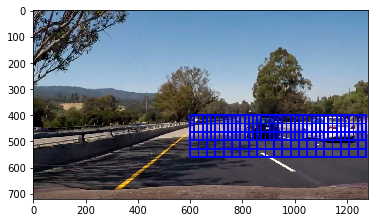

In [41]:
image = mpimg.imread(test_images[0])

windows = []

window1 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 700], 
                    xy_window=(256, 256), xy_overlap=(0.75, 0.))
window2 = slide_window(image, x_start_stop=[600, None], y_start_stop=[400, 575], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window3 = slide_window(image, x_start_stop=[600, None], y_start_stop=[400, 500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.5))
   
windows =  window2  + window3
print(len(windows))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Search Windows

In [42]:
def single_image_features(img, cspace='RGB', spatial_size=(32, 32),
                          hist_bins=32, hist_range=(0, 256), orient=8, 
                          pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    feature_image = cvt_color(img, cspace)
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() to get color histogram features
    _,_,_,_,color_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Apply get_hog_features() to get HOG features
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, color_features, hog_features)))
    # Return list of feature vectors
    return features

In [43]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=8, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]],  (64, 64))   
        
        #lt.imshow(test_img)
        #plt.show()
        #4) Extract features for that window using single_img_features()
        features = single_image_features(test_img, cspace=color_space, spatial_size=spatial_size,
                                         hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                         pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.asarray(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #print(prediction)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


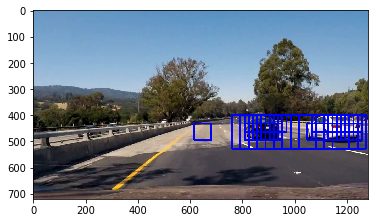

In [44]:
image = mpimg.imread(test_images[5])
image = image.astype(np.float32)/255


hot_windows = search_windows(image, windows, clf_loaded, X_scaler,
                             color_space=colorspace, spatial_size=spatial_size,
                             hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)                       

draw_image = np.copy(image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

### Add Heatmap

In [45]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


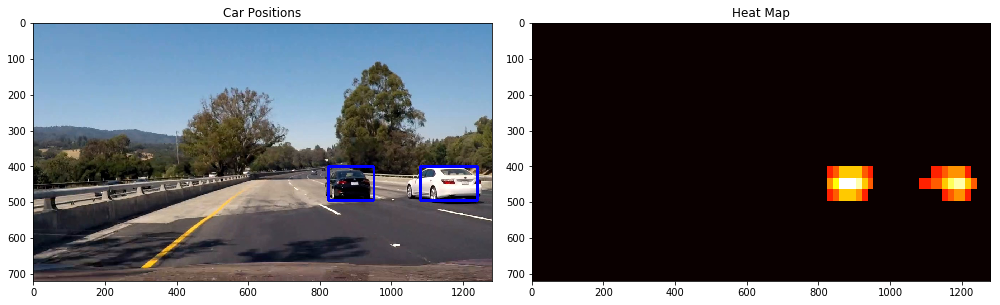

In [54]:
image = mpimg.imread('test_images/bug.jpg')
image = image.astype(np.float32)/255

hot_windows = search_windows(image, windows, clf_loaded, X_scaler,
                             color_space=colorspace, spatial_size=spatial_size,
                             hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)                       


# Create heat map equal image 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 4)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [47]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        self.frames = 0
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]
    def add_frames(self):
        self.frames+=1

        
print('...')

...


In [48]:
def pipeline(image):
    
    hot_windows = search_windows(image.astype(np.float32)/255, windows, clf_loaded, X_scaler,
                                 color_space=colorspace, spatial_size=spatial_size,
                                 hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)                       


    # Create heat map equal image 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

def pipeline_2(image):
    
    hot_windows = search_windows(image.astype(np.float32)/255, windows, clf_loaded, X_scaler,
                                 color_space=colorspace, spatial_size=spatial_size,
                                 hist_bins=hist_bins, hist_range=hist_range, orient=orient,
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)                       
    
    # add detections to the history
    if len(hot_windows) > 0:
        det.add_rects(hot_windows)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for rect_set in det.prev_rects:
        heat = add_heat(heat, rect_set)

    heat = apply_threshold(heat,  1 + len(det.prev_rects)//2)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
     
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    det.add_frames()
    
    return draw_img

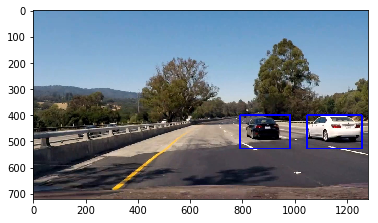

In [53]:
imageeee = mpimg.imread('test_images/bug.jpg')
det = Vehicle_Detect()
def process_image(image):
    
    return pipeline_2(image)

plt.imshow(process_image(imageeee))


In [55]:
det = Vehicle_Detect()
project_output = 'output/project_video_output_pp4.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(15,25)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output/project_video_output_pp4.mp4
[MoviePy] Writing video output/project_video_output_pp4.mp4


100%|█████████▉| 250/251 [05:09<00:01,  1.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video_output_pp4.mp4 

CPU times: user 20min 23s, sys: 16.2 s, total: 20min 39s
Wall time: 5min 10s


In [32]:
save = white_clip.get_frame(1)

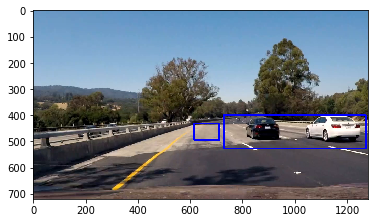

In [51]:
plt.imshow(white_clip.get_frame(1.25))

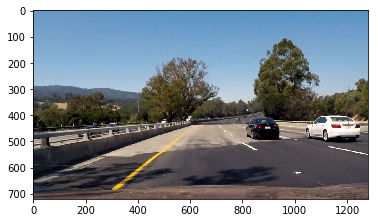

In [52]:
plt.imshow(clip1.get_frame(1.25))

mpimg.imsave('test_images/bug.jpg', clip1.get_frame(1.25))

In [110]:
for i in range(0, 20):
    imagem = clip1.get_frame(i/10)
    mpimg.imsave('test_images/test_problem{}.jpg'.format(i), imagem)

In [10]:
problems = glob.glob('test_images/test_problem*.jpg')
i=0
for problem in problems:
    
    image = mpimg.imread(problem)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.8, 0.8))
    
    for window in windows:

        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]],  (64, 64))   
        mpimg.imsave('test_images/crop/crop{}.png'.format(i), test_img)
        i+=1
    
    